**CITS4404 - AI and Adaptive Systems**

**Alibi explainer model - with prototype**

**Fashion MNIST**

**7th October 2020**

Install the required packages

In [1]:
!pip install alibi

     |████████████████████████████████| 225kB 7.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 327kB 15.1MB/s 
     |████████████████████████████████| 204kB 19.1MB/s 
     |████████████████████████████████| 28.0MB 100kB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456465 sha256=461c32c485205121029bcd891589deb9492efbc9566e3d2b13c0354e99474571
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=645b3d24bb451d45993f019557a302af34fd2c7813b13cbcb0ea12d27a607f60
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [2]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import CounterFactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


Downloand the data and select the instance for examination by changing 'idx':

In [3]:
idx = 1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


Re shape the data

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [5]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

Define our cnn:

In [6]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [7]:
cnn = cnn_model()
cnn.fit(x_train, y_train, batch_size=32, epochs=3, verbose=0)
cnn.save('mnist_cnn.h5', save_format='h5')

Run and evaluate the model:

In [8]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.887


In [9]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(14, 14, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

In [10]:
ae, enc, dec = ae_model()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')
enc.save('mnist_enc.h5', save_format='h5')

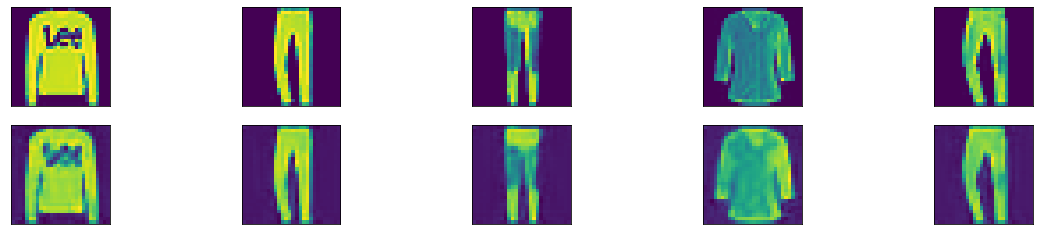

In [11]:
enc = load_model('mnist_enc.h5', compile=False)

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

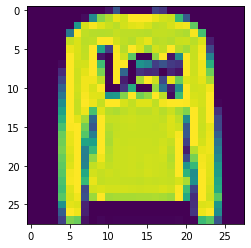

In [12]:
X = x_test[idx].reshape((1,) + x_test[0].shape)
plt.imshow(X.reshape(28, 28));

Define some parameters for our explainer:

In [13]:
shape = (1,) + x_train.shape[1:]
gamma = 100.
theta = 100.
c_init = 1.
c_steps = 2
max_iterations = 1000
feature_range = (x_train.min(),x_train.max())

Initialise the explainer, with prototype option

In [14]:
cf = CounterFactualProto(cnn, shape, gamma=gamma, theta=theta,
                         ae_model=ae, enc_model=enc, max_iterations=max_iterations,
                         feature_range=feature_range, c_init=c_init, c_steps=c_steps)
start_time = time()
cf.fit(x_train)  # find class prototypes

explanation = cf.explain(X)


View the image class and basic explanation

Counterfactual prediction: Shirt
Closest prototype class: Coat


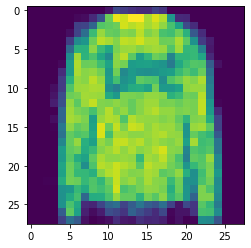

In [15]:
class_label=['T-shirt/top','Trouser','Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker','Bag', 'Ankle boot']
print('Counterfactual prediction: {}'.format(class_label[explanation.cf['class']]))
print('Closest prototype class: {}'.format(class_label[explanation.id_proto]))
plt.imshow(explanation.cf['X'].reshape(28, 28));

View counterfactual with prototype applied

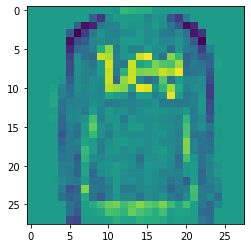

In [16]:
plt.imshow((explanation.cf['X'] - X).reshape(28, 28));